A journey to figure out wtf is going on why doesn't it train

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

from models import MLP, MovementPredictor
from train import get_data
from util.data import ROIS  # Custom set of ROIs we're trying to model
from util.misc import grad_norm, set_seed

In [2]:
%matplotlib inline

In [3]:
tr_dataset, ts_dataset = get_data()

Loading cached data from /scratch/users/akashc/misc_proj/cs339n/final/connectx-decoding/data/raw_data.pkl
Recording 4b7fbad4-f6de-43b4-9b15-c7c7ef44db4b: 792 trials, T=120
(792, 120) (792,)
(792, 120) (792,)
(792, 120) (792,)
(792, 120) (792,)
(792, 120) (792,)
(792, 120) (792,)
eid='4b7fbad4-f6de-43b4-9b15-c7c7ef44db4b' all_inputs[-1].shape=(792, 6, 120)
Recording e2b845a1-e313-4a08-bc61-a5f662ed295e: 469 trials, T=120
(469, 120) (469,)
(469, 120) (469,)
(469, 120) (469,)
(469, 120) (469,)
(469, 120) (469,)
(469, 120) (469,)
eid='e2b845a1-e313-4a08-bc61-a5f662ed295e' all_inputs[-1].shape=(469, 6, 120)
Recording f312aaec-3b6f-44b3-86b4-3a0c119c0438: 621 trials, T=120
(621, 120) (621,)
(621, 120) (621,)
(621, 120) (621,)
(621, 120) (621,)
(621, 120) (621,)
(621, 120) (621,)
eid='f312aaec-3b6f-44b3-86b4-3a0c119c0438' all_inputs[-1].shape=(621, 6, 120)
Recording 6c6b0d06-6039-4525-a74b-58cfaa1d3a60: 994 trials, T=120
(994, 120) (994,)
(994, 120) (994,)
(994, 120) (994,)
(994, 120) (994,)


In [4]:
one_x, one_y = tr_dataset[0]

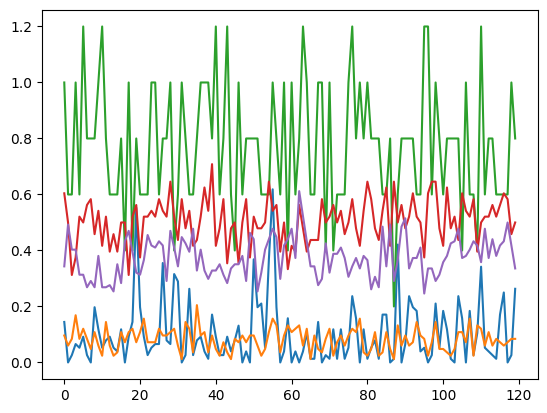

In [6]:
plt.plot(one_x[[0, 1, 2, 3, 5]].T)

In [8]:
assert torch.cuda.is_available()
device = torch.device('cuda')

In [9]:
mdl = MLP(3, np.prod(one_x.shape), 32, 1).to(device)

In [10]:
mdl

MLP(
  (initial_proj): Linear(in_features=720, out_features=32, bias=True)
  (mlp): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): GELU(approximate='none')
  )
  (out_proj): Linear(in_features=32, out_features=1, bias=True)
)

In [11]:
x_torch, y_torch = torch.tensor(one_x).to(device).float()[None, ...], torch.tensor(one_y).to(device).float()[None, None, ...]

In [12]:
optimizer = torch.optim.SGD(mdl.parameters(), lr=3e-1)

In [13]:
for i in tqdm(range(100)):
    optimizer.zero_grad()
    logit = mdl(x_torch.flatten(1))
    loss = F.binary_cross_entropy_with_logits(logit, y_torch)
    loss.backward()
    
    gnorm = grad_norm(mdl)

    optimizer.step()
    
    print(f"{i}: Loss {loss.item()}\tGrad norm {gnorm.item()}")

  0%|          | 0/100 [00:00<?, ?it/s]

0: Loss 0.6270407438278198	Grad norm 0.5240752696990967
1: Loss 0.5487273335456848	Grad norm 0.47341254353523254
2: Loss 0.48447704315185547	Grad norm 0.4320598542690277
3: Loss 0.4307898283004761	Grad norm 0.396857887506485
4: Loss 0.38537609577178955	Grad norm 0.3666066825389862
5: Loss 0.3466077148914337	Grad norm 0.33934202790260315
6: Loss 0.31323549151420593	Grad norm 0.3166423738002777
7: Loss 0.2841292917728424	Grad norm 0.2966318726539612
8: Loss 0.25850650668144226	Grad norm 0.2795906960964203
9: Loss 0.23568116128444672	Grad norm 0.26506391167640686
10: Loss 0.21510139107704163	Grad norm 0.2530116140842438
11: Loss 0.19627784192562103	Grad norm 0.2435595989227295
12: Loss 0.17874698340892792	Grad norm 0.23704594373703003
13: Loss 0.16203105449676514	Grad norm 0.2340676635503769
14: Loss 0.14559102058410645	Grad norm 0.23545348644256592
15: Loss 0.12884119153022766	Grad norm 0.24071341753005981
16: Loss 0.11112205684185028	Grad norm 0.2512523829936981
17: Loss 0.0917644873261

In [14]:
model = MovementPredictor(num_regions=len(ROIS)).to(device)
new_optimizer = torch.optim.SGD(model.parameters(), 1e-1, momentum=0.9)

In [15]:
for i in tqdm(range(100)):
    new_optimizer.zero_grad()
    logit = model(x_torch)
    loss = F.binary_cross_entropy_with_logits(logit, y_torch)
    loss.backward()
    
    gnorm = grad_norm(model)

    new_optimizer.step()
    
    print(f"{i}: Loss {loss.item()}\tGrad norm {gnorm.item()}")

  0%|          | 0/100 [00:00<?, ?it/s]

0: Loss 0.701572835445404	Grad norm 0.5925611257553101
1: Loss 0.6671082973480225	Grad norm 0.5710621476173401
2: Loss 0.6062185764312744	Grad norm 0.5338272452354431
3: Loss 0.5287200212478638	Grad norm 0.48755204677581787
4: Loss 0.44397133588790894	Grad norm 0.4374696612358093
5: Loss 0.35961538553237915	Grad norm 0.38625863194465637
6: Loss 0.28125521540641785	Grad norm 0.33464768528938293
7: Loss 0.2125869244337082	Grad norm 0.28296640515327454
8: Loss 0.15558207035064697	Grad norm 0.23236972093582153
9: Loss 0.11064501106739044	Grad norm 0.18493463099002838
10: Loss 0.07688149064779282	Grad norm 0.14288169145584106
11: Loss 0.05255231633782387	Grad norm 0.10768266022205353
12: Loss 0.0355987586081028	Grad norm 0.07969497889280319
13: Loss 0.024067038670182228	Grad norm 0.058341220021247864
14: Loss 0.01634025387465954	Grad norm 0.042533036321401596
15: Loss 0.011198407039046288	Grad norm 0.031061843037605286
16: Loss 0.007777054328471422	Grad norm 0.022830402478575706
17: Loss 0.

In [16]:
uncollated_batch = tr_dataset[:8]
xs, ys = torch.tensor([item[0] for item in uncollated_batch]).float().to(device), torch.tensor([item[1] for item in uncollated_batch]).to(device).float()[:, None]
ys = ys.masked_fill(ys < 0, 0)  # account for dataset providing -1 as label (from behavior)

/tmp/ipykernel_9151/2759852404.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  xs, ys = torch.tensor([item[0] for item in uncollated_batch]).float().to(device), torch.tensor([item[1] for item in uncollated_batch]).to(device).float()[:, None]


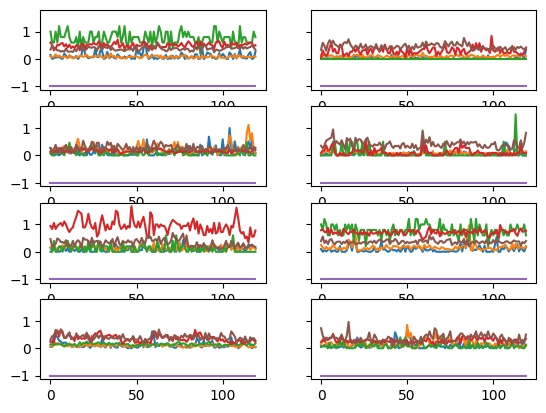

In [17]:
_, axs = plt.subplots(4, 2, sharey=True)
axs = [a for ax in axs for a in ax]
for ax, ex in zip(axs, xs.cpu()):
    ax.plot(ex.T)

In [18]:
# model = MovementPredictor(num_regions=len(ROIS), num_convs=5).to(device)
model = MLP(7, 720, 1024, 1).to(device)
new_optimizer = torch.optim.SGD(model.parameters(), 1e-3, momentum=0.9)

In [25]:
bss, final_losses = [], []
for bs in (2 ** np.arange(6)):
    uncollated_batch = tr_dataset[:bs]
    xs, ys = torch.tensor([item[0] for item in uncollated_batch]).float().to(device), torch.tensor([item[1] for item in uncollated_batch]).to(device).float()[:, None]
    ys = ys.masked_fill(ys < 0, 0)  # account for dataset providing -1 as label (from behavior)
    
    model = MLP(7, 720, 1024, 1).to(device)
    new_optimizer = torch.optim.SGD(model.parameters(), 1e-3, momentum=0.9)

    for i in tqdm(range(1000), desc=f'Overfitting batch of size {bs}'):
        new_optimizer.zero_grad()
        logit = model(xs.flatten(1))
        loss = F.binary_cross_entropy_with_logits(logit, ys)
        loss.backward()

        gnorm = grad_norm(model)
        new_optimizer.step()

    bss.append(bs)
    final_losses.append(loss.item())

Overfitting batch of size 1:   0%|          | 0/1000 [00:00<?, ?it/s]

Overfitting batch of size 2:   0%|          | 0/1000 [00:00<?, ?it/s]

Overfitting batch of size 4:   0%|          | 0/1000 [00:00<?, ?it/s]

Overfitting batch of size 8:   0%|          | 0/1000 [00:00<?, ?it/s]

Overfitting batch of size 16:   0%|          | 0/1000 [00:00<?, ?it/s]

Overfitting batch of size 32:   0%|          | 0/1000 [00:00<?, ?it/s]

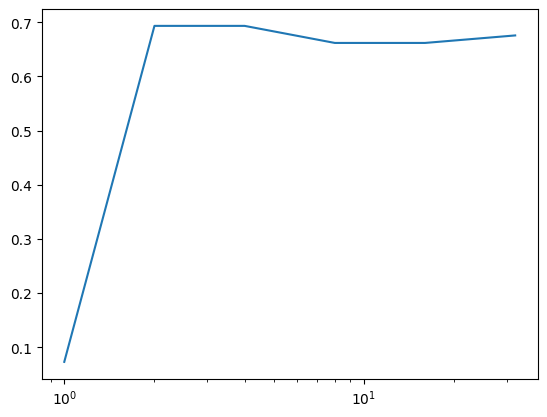

In [27]:
plt.plot(bss, final_losses)
plt.xscale('log')